# DONE:

- x include non-Metaphor data and label

- repeat experiments after sampling original sentences, not random sampling

- fix the damn indentation on the accuracy

- Try freezing some layers. Hopefully reduces training time (significantly)

- FIXING BERT TOKENIZER TO REDEWIEDERGABE!!!

- make use of cuda or mps nicer

- increase freeze rate (Dropped performance slightly)

- add additional dropout layer (not really sure if it helped)

# NOW:

- include loss and score plots

# TODO:
    
- include F1-score in evaluation

- x test F1-score loss function
    - https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook
    - not avaiable for mps yet!


In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

np.random.seed(3093453)
sns.set(context="talk", style="darkgrid")

In [2]:
cwd = os.getcwd()
folder = "clean+translated-data"
file = "total.csv"
path = "/".join( (cwd, folder, file) )

df = pd.read_csv(path, index_col=0)
#df.reset_index(inplace=True)
df

,index,Textstelle,Metapher,Metaphernkandidat,Nein,Metapher?,Fokus,Rahmen,Annotator,orig,lang,sentence_id
0,0,Der politische Körper verwendet in beiden Fäll...,3,1,0,Metapher,"['Zähnen und Krallen', 'Zähnen und Krallen', n...","['der politische Körper', 'der politische Körp...","['B', 'K', 'A', 'GoldStandard']","""Der politische Körper verwendet in beiden Fä...",de,0
1,1,Immer noch wird durch die protestantische Lehr...,0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Immer noch wird durch die protestantische Le...",de,1
2,2,"Kein Zweifel, schreibt Alb. Schaeffle, vorauss...",0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Kein Zweifel"", schreibt Alb. Schaeffle 1), v...",de,2
3,3,Mit je weiterem Blick wir die Stoffwelt zu übe...,1,3,0,Metaphernkandidat,"[nan, 'Stoffwelt, verzwergt und entkleidet', n...","[nan, 'unser praktisches Ideal', nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Mit je weiterem Blick wir die Stoffwelt zu ü...",de,3
4,4,Solange das Menschengeschlecht seinen Zerstöre...,0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Solange das Menschengeschlecht seinen Zerstö...",de,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3960,3960,In der Zeit des Humanismus und der Reformation...,0,0,1,Nein,NaN,NaN,X,In der Zeit des Humanismus und der Reformation...,de,4759
3961,3961,Den Mittelpunkt der Bildung stellten die alten...,0,0,1,Nein,NaN,NaN,X,Den Mittelpunkt der Bildung stellten die alten...,de,4760
3962,3962,Jahrhunderts hat eine beständige Differenzieru...,0,0,1,Nein,NaN,NaN,X,Jahrhunderts hat eine beständige Differenzieru...,de,4761
3963,3963,Die Pädagogik der Neuzeit scheint davon wenig ...,0,0,1,Nein,NaN,NaN,X,Die Pädagogik der Neuzeit scheint davon wenig ...,de,4762


## Sentence ID

We need to do this to make sure we dont have a german sentence in the train data
... and a english version in the test data, which skewes the results

(Essentially the model would just memorize seen points, rather than learn what a metaphor is)



In [3]:
labs = ["Metapher", "Metaphernkandidat", "Nein"]
labels = dict(zip(range(3), labs))

# impute missing labels with silver labels
missing_lab = df["Metapher?"].isnull()
df.loc[missing_lab, "Metapher?"] = [labels[i] for i in df.loc[missing_lab, labs].to_numpy().argmax(axis=1)]

# BERT CLASSIFIER

https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

## DATASET

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("redewiedergabe/bert-base-historical-german-rw-cased")

# Later: non-Metaphor: 0, Candidate: 1, Metaphor: 2
labs = ["Metapher", "Metaphernkandidat", "Nein"]

labels = dict(zip(labs, range(3)))
labels

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        # gold and silver labels
        
        self.labels = [labels[label] for label in df["Metapher?"]]
        self.labels = df[labs].to_numpy().argmax(axis=1)
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Textstelle']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

## Train test split:

create a original-sentence id

We need to do this to make sure we dont have a german sentence in the train data and a english version in the test 
data, which skewes the results

(Essentially the model would just memorize seen points, rather than learn what a metaphor is)

In [5]:
unique_sentences = df.orig.unique()

sentence_id = [np.where(sentence == unique_sentences)[0].item() for sentence in df.orig]
df["sentence_id"] = sentence_id

unique_sentence_ids = df.sentence_id.unique()
n_unique_sentences = len(unique_sentence_ids)


# randomize data before splitting
sample = np.random.choice(unique_sentence_ids, n_unique_sentences, replace=False)

# train/val/test split of original sentences
train_sentence_ids,val_sentence_ids,test_sentence_ids = np.split(sample,
                                                                 [int(.8*n_unique_sentences),
                                                                  int(.9*n_unique_sentences)])

print(len(train_sentence_ids),len(val_sentence_ids), len(test_sentence_ids))

# train/val/test split rows
df_train = df[np.isin(df.sentence_id, train_sentence_ids)]
df_val   = df[np.isin(df.sentence_id, val_sentence_ids  )]
df_test  = df[np.isin(df.sentence_id, test_sentence_ids )]

print(len(df_train),len(df_val), len(df_test))

3811 476 477
6411 804 745


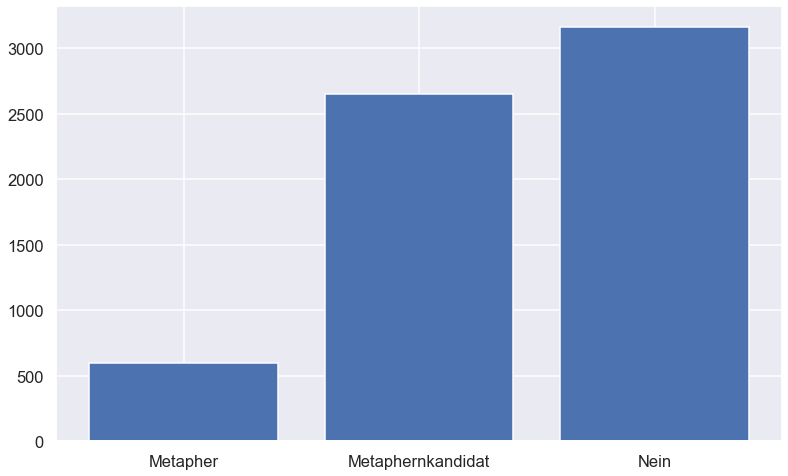

In [6]:
vc = pd.Series([labels[label] for label in df_train["Metapher?"]]).value_counts()

fig, ax = plt.subplots(figsize=(13, 8))
plt.bar(vc.index, vc)
plt.xticks(range(3),labs);

## Building a Bert Model

In [7]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5, freeze = 0.8):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained("redewiedergabe/bert-base-historical-german-rw-cased")
        
        params = self.bert.parameters()
        for i, param in enumerate(params):
            if i > 197 * freeze:
                continue
            param.requires_grad = False
            
        self.dropout1    = nn.Dropout(dropout)
        self.linear1     = nn.Linear(768, 768)
        self.activation1 = nn.ReLU(inplace=False)
        self.dropout2    = nn.Dropout(dropout)
        self.linear2     = nn.Linear(768, 3)
        self.softmax     = nn.Softmax(dim=1)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        
        dropout_output1 = self.dropout1(pooled_output)
        linear_output1 = self.linear1(dropout_output1)
        activation1 = self.activation1(linear_output1)
        
        dropout_output2 = self.dropout2(activation1)
        linear_output2 = self.linear2(dropout_output2)
        
        final_layer = self.softmax(linear_output2)

        return final_layer
    
model = BertClassifier()

Some weights of the model checkpoint at redewiedergabe/bert-base-historical-german-rw-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)   
        inputs = inputs.softmax(dim=-1)
        
        # turn target from indices to n x 3 dummy tensor
        bs = len(targets)
        y = torch.zeros(bs,3)
        y[torch.arange(0, bs), targets.long()] = 1
        targets = y
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [9]:
import torch.nn.functional as F

#PyTorch
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        # turn target from indices to n x 3 dummy tensor
        bs = len(targets)
        y = torch.zeros(bs,3)
        y[torch.arange(0, bs), targets.long()] = 1
        targets = y
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [10]:
loss_functions = [nn.CrossEntropyLoss,
                  #FocalLoss,
                  DiceLoss]

for func in loss_functions:
    print(func.__name__)

CrossEntropyLoss
DiceLoss


In [11]:
model1 = BertClassifier()
model2 = BertClassifier()
model3 = BertClassifier()

models = [model1,
          #model2,
          model3]


Some weights of the model checkpoint at redewiedergabe/bert-base-historical-german-rw-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at redewiedergabe/bert-base-historical-german-rw-cased were not used when initializi

In [12]:
metric_df = pd.DataFrame({"epoch":[],
                          "loss_func":[],
                          "metric": [],
                          "label": [],
                          "score":[]})
metric_df

,epoch,loss_func,metric,label,score


In [13]:

def smallestDivisor(n):
    """helper function for validation set"""
    # if divisible by 2
    if (n % 2 == 0):
        return 2;
 
    # iterate from 3 to sqrt(n)
    i = 3;
    while(i * i <= n):
        if (n % i == 0):
            return i;
        i += 2;
 
    return n;

In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

from torch.optim import Adam
from tqdm.notebook import tqdm

import time




def train(model, train_data, val_data,
          epochs=1, learning_rate=1e-6,
          LossFunction = nn.CrossEntropyLoss,
          df = metric_df, batch_size = 8):
    
    # Basic setup: data, criterion, optimizer
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_batch_size = smallestDivisor(len(val))
    #val_batch_size=4
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=val_batch_size)
    
    criterion = LossFunction()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    
    # make use of GPU acceleration if available
    # Custom Loss functions are sadly not supported yet :(
    
    if torch.backends.mps.is_available() and LossFunction.__name__ == "CrossEntropyLoss":
        use_device = "mps"
        print("Using M1 Chip! for training")

    elif torch.cuda.is_available():
        use_device = "cuda"
        print("Using Graphics Card for training")
    else:
        use_device = "cpu"
        print("Using regular CPU for training")

    device = torch.device(use_device)
    model = model.to(device)
    criterion = criterion.to(device)
    
    #plot metrics:
    metric_df = pd.DataFrame({"epoch":[],
                              "loss_func":[],
                              "metric": [],
                              "label": [],
                              "score":[]})
    # training loop
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):
                
                # preprocessing
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                
                # prediction
                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                # scores
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                
                # actual training
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            

            y_test_prob = np.empty((len(df_val), 3), float)

            test_labels = np.zeros((len(df_val)), int)

            with torch.no_grad():

                    i = 0
                    for test_input, test_label in val_dataloader:

                        #test_label = test_label.to(device)
                        test_labels[i*val_batch_size:(i+1)*val_batch_size] = test_label.cpu()

                        mask = test_input['attention_mask'].to(device)
                        input_id = test_input['input_ids'].squeeze(1).to(device)

                        y_test_prob[i*val_batch_size:(i+1)*val_batch_size] = model(input_id, mask).cpu()

                        i+=1

            # calculate labels
            y_test_true = np.zeros((len(df_val), 3))
            y_test_true[np.arange(len(df_val)),test_labels] = 1

            test_preds = y_test_prob.argmax(axis=1)
            y_test_pred = np.zeros((len(df_val), 3))
            y_test_pred[np.arange(len(df_val)),test_preds] = 1
            
            print(f'Epochs: {epoch_num + 1}')
            
            
            for i, lab in enumerate(labs):
                prec, recall, _ = precision_recall_curve(y_test_true[:,i], y_test_prob[:,i])
                avg_prec = average_precision_score(y_test_true[:,i], y_test_prob[:,i])
                
                entry = pd.DataFrame({"epoch":[epoch_num],
                                      "loss_func":[LossFunction.__name__],
                                      "metric": ["avg-prc"],
                                      "label": [lab],
                                      "score":[avg_prec]})
                metric_df = pd.concat([metric_df, entry])
                
            print("F1 scores:\n"+"-"*23)
            for i, lab in enumerate(labs):
                f1 = f1_score(y_test_true[:,i], y_test_pred[:,i], average = "binary")
                print(f"{lab:>17}: {f1:.2f}")
                
                entry = pd.DataFrame({"epoch":[epoch_num],
                                      "loss_func":[LossFunction.__name__],
                                      "metric": ["f1"],
                                      "label": [lab],
                                      "score":[f1]})
                metric_df = pd.concat([metric_df, entry])
            
            # save intermediate dataframe
            cwd = os.getcwd()
            folder = "intermediate_metrics"
            file = f"intermediate-results-{time.time()}.csv"
            path = "/".join( (cwd, folder, file) )
            metric_df.to_csv(path)
    
    return metric_df

In [15]:
for i, model in enumerate(models):
    print(f"training on {loss_functions[i].__name__}")
    history = train(model, df_train, df_test,
                    epochs=18, LossFunction = loss_functions[i])
    metric_df = pd.concat([metric_df, history])
    print("-"*80)

training on CrossEntropyLoss
Using M1 Chip! for training


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 1
F1 scores:
-----------------------
         Metapher: 0.62
Metaphernkandidat: 0.30
             Nein: 0.67


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 2
F1 scores:
-----------------------
         Metapher: 0.61
Metaphernkandidat: 0.29
             Nein: 0.73


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 3
F1 scores:
-----------------------
         Metapher: 0.54
Metaphernkandidat: 0.61
             Nein: 0.80


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 4
F1 scores:
-----------------------
         Metapher: 0.55
Metaphernkandidat: 0.65
             Nein: 0.82


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 5
F1 scores:
-----------------------
         Metapher: 0.61
Metaphernkandidat: 0.69
             Nein: 0.83


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 6
F1 scores:
-----------------------
         Metapher: 0.54
Metaphernkandidat: 0.69
             Nein: 0.84


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 7
F1 scores:
-----------------------
         Metapher: 0.54
Metaphernkandidat: 0.71
             Nein: 0.84


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 8
F1 scores:
-----------------------
         Metapher: 0.54
Metaphernkandidat: 0.70
             Nein: 0.86


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 9
F1 scores:
-----------------------
         Metapher: 0.21
Metaphernkandidat: 0.70
             Nein: 0.84


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 10
F1 scores:
-----------------------
         Metapher: 0.54
Metaphernkandidat: 0.73
             Nein: 0.86


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 11
F1 scores:
-----------------------
         Metapher: 0.54
Metaphernkandidat: 0.73
             Nein: 0.86


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 12
F1 scores:
-----------------------
         Metapher: 0.55
Metaphernkandidat: 0.74
             Nein: 0.89


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 13
F1 scores:
-----------------------
         Metapher: 0.55
Metaphernkandidat: 0.74
             Nein: 0.88


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 14
F1 scores:
-----------------------
         Metapher: 0.54
Metaphernkandidat: 0.74
             Nein: 0.88


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 15
F1 scores:
-----------------------
         Metapher: 0.54
Metaphernkandidat: 0.75
             Nein: 0.88


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 16
F1 scores:
-----------------------
         Metapher: 0.55
Metaphernkandidat: 0.75
             Nein: 0.88


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 17
F1 scores:
-----------------------
         Metapher: 0.55
Metaphernkandidat: 0.74
             Nein: 0.89


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 18
F1 scores:
-----------------------
         Metapher: 0.55
Metaphernkandidat: 0.75
             Nein: 0.89
--------------------------------------------------------------------------------
training on DiceLoss
Using regular CPU for training


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 1
F1 scores:
-----------------------
         Metapher: 0.23
Metaphernkandidat: 0.03
             Nein: 0.70


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 2
F1 scores:
-----------------------
         Metapher: 0.41
Metaphernkandidat: 0.01
             Nein: 0.70


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 3
F1 scores:
-----------------------
         Metapher: 0.49
Metaphernkandidat: 0.59
             Nein: 0.80


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 4
F1 scores:
-----------------------
         Metapher: 0.29
Metaphernkandidat: 0.65
             Nein: 0.82


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 5
F1 scores:
-----------------------
         Metapher: 0.36
Metaphernkandidat: 0.67
             Nein: 0.83


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 6
F1 scores:
-----------------------
         Metapher: 0.26
Metaphernkandidat: 0.67
             Nein: 0.83


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 7
F1 scores:
-----------------------
         Metapher: 0.23
Metaphernkandidat: 0.68
             Nein: 0.82


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 8
F1 scores:
-----------------------
         Metapher: 0.21
Metaphernkandidat: 0.67
             Nein: 0.83


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 9
F1 scores:
-----------------------
         Metapher: 0.24
Metaphernkandidat: 0.68
             Nein: 0.84


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 10
F1 scores:
-----------------------
         Metapher: 0.26
Metaphernkandidat: 0.69
             Nein: 0.84


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 11
F1 scores:
-----------------------
         Metapher: 0.21
Metaphernkandidat: 0.68
             Nein: 0.84


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 12
F1 scores:
-----------------------
         Metapher: 0.52
Metaphernkandidat: 0.71
             Nein: 0.85


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 13
F1 scores:
-----------------------
         Metapher: 0.30
Metaphernkandidat: 0.69
             Nein: 0.84


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 14
F1 scores:
-----------------------
         Metapher: 0.22
Metaphernkandidat: 0.69
             Nein: 0.84


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 15
F1 scores:
-----------------------
         Metapher: 0.28
Metaphernkandidat: 0.69
             Nein: 0.84


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 16
F1 scores:
-----------------------
         Metapher: 0.52
Metaphernkandidat: 0.71
             Nein: 0.86


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 17
F1 scores:
-----------------------
         Metapher: 0.34
Metaphernkandidat: 0.70
             Nein: 0.86


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 18
F1 scores:
-----------------------
         Metapher: 0.27
Metaphernkandidat: 0.70
             Nein: 0.85
--------------------------------------------------------------------------------


In [16]:
cwd = os.getcwd()
folder = "intermediate_metrics"
file = f"results.csv"
path = "/".join( (cwd, folder, file) )
metric_df.to_csv(path)

In [17]:
a

NameError: name 'a' is not defined

In [23]:
cwd = os.getcwd()
folder = "intermediate_metrics"
file = f"results.csv"
path = "/".join( (cwd, folder, file) )
metric_df = pd.read_csv(path)
metric_df

,Unnamed: 0,epoch,loss_func,metric,label,score
0,0,0.0,CrossEntropyLoss,avg-prc,Metapher,0.133009
1,0,0.0,CrossEntropyLoss,avg-prc,Metaphernkandidat,0.386325
2,0,0.0,CrossEntropyLoss,avg-prc,Nein,0.577153
3,0,0.0,CrossEntropyLoss,f1,Metapher,0.620321
4,0,0.0,CrossEntropyLoss,f1,Metaphernkandidat,0.299287
...,...,...,...,...,...,...
319,0,17.0,DiceLoss,avg-prc,Metaphernkandidat,0.756077
320,0,17.0,DiceLoss,avg-prc,Nein,0.929134
321,0,17.0,DiceLoss,f1,Metapher,0.268456
322,0,17.0,DiceLoss,f1,Metaphernkandidat,0.699029


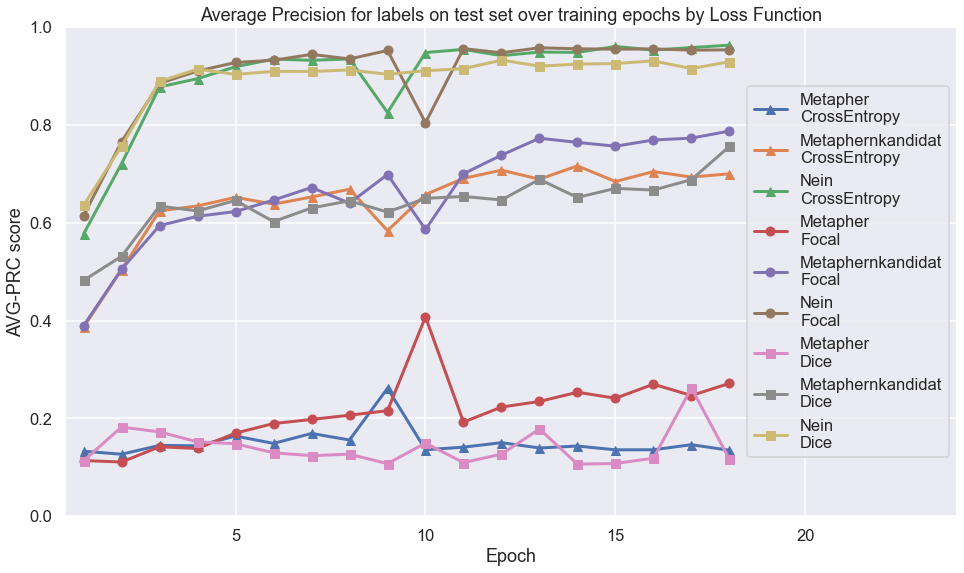

In [56]:
plt.figure(figsize=(16, 9))
markers = ["^", "o", "s"]
for i, lf in enumerate(metric_df.loss_func.unique()):
    for lab in metric_df.label.unique():
        data = metric_df[(metric_df.loss_func == lf) & 
                         (metric_df.label == lab) &
                         (metric_df.metric == "avg-prc")]
        marker = markers[i]
        plt.plot(data.epoch+1, data.score, lw = 3,
                 marker = marker,
                 label = f"{lab:}\n{lf[:-4]:}")
        
plt.legend(loc = "center right")
plt.xlabel("Epoch")
plt.xlim([0.5, 24]);
plt.ylabel("AVG-PRC score")
plt.ylim([0, 1]);
plt.title("Average Precision for labels on test set over training epochs by Loss Function");

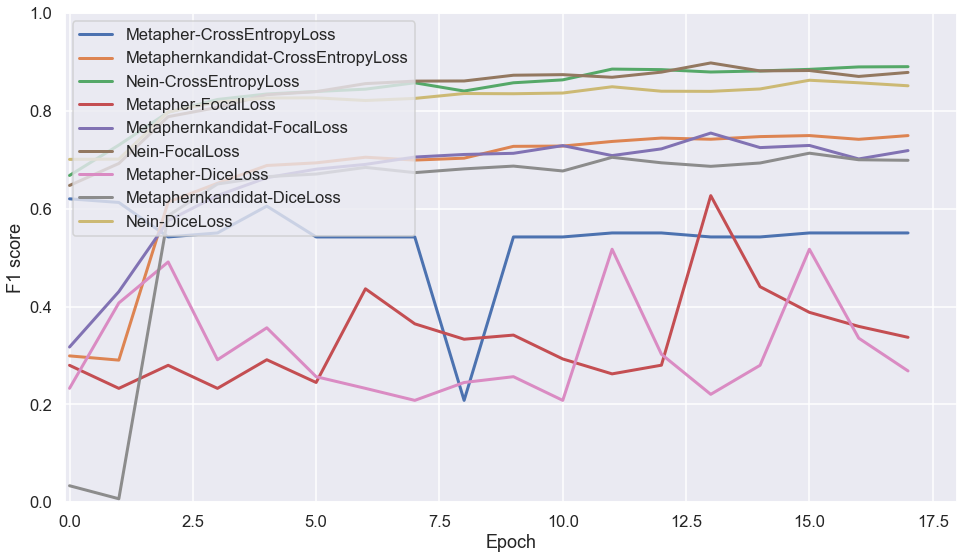

In [31]:
plt.figure(figsize=(16, 9))
for lf in metric_df.loss_func.unique():
    for lab in metric_df.label.unique():
        data = metric_df[(metric_df.loss_func == lf) & (metric_df.label == lab) & (metric_df.metric == "f1")]
        plt.plot(data.epoch, data.score, lw = 3, label = f"{lab}-{lf}")
        
plt.legend(loc = "upper left")
plt.xlabel("Epoch")
plt.xlim([-0.1, 18]);
plt.ylabel("F1 score")
plt.ylim([0, 1]);

# Error analysis

In [ ]:
test = Dataset(df_test)

batch_size=5

test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

if torch.backends.mps.is_available():
    use_device = "mps"
    print("Using M1 Chip!")

elif torch.cuda.is_available():
    use_device = "cuda"
    print("Using Graphics Card")
else:
    use_device = "cpu"
    print("Using regular CPU")
        
device = torch.device(use_device)
model = model.to(use_device)



y_test_prob = np.empty((len(df_test), 3), float)

test_labels = np.zeros((len(df_test)), int)

with torch.no_grad():
    
        i = 0
        for test_input, test_label in test_dataloader:
            
            test_label = test_label.to(device)
            test_labels[i*batch_size:(i+1)*batch_size] = test_label.cpu()
            
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            
            y_test_prob[i*batch_size:(i+1)*batch_size] = model(input_id, mask).cpu()
            
            i+=1

# calculate labels
y_test_true = np.zeros((len(df_test), 3))
y_test_true[np.arange(len(df_test)),test_labels] = 1

test_preds = y_test_prob.argmax(axis=1)
y_test_pred = np.zeros((len(df_test), 3))
y_test_pred[np.arange(len(df_test)),test_preds] = 1

In [ ]:
for i in range(3):
    plt.hist(y_test_prob[:,i],
             bins=np.arange(0,1,0.05),
             alpha=0.5
            )

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(13, 8))
for i in range(3):
    prec, recall, _ = precision_recall_curve(y_test_true[:,i], y_test_prob[:,i])
    avg_prec = average_precision_score(y_test_true[:,i], y_test_prob[:,i])
    label = f"{labs[i]}:  {avg_prec:.3f}"
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax,label=label)
    
plt.title("Average Precision Curve after training on Focal Loss");

In [ ]:
#ALPHA GAMMA Epochs was metapher / kandidat / nein

# 0.8, 2, 6: was 0.229 / 0.732 / 0.950
# 0.8, 2, 7: was 0.252 / 0.764 / 0.956
# 0.8, 2, 8: was 0.277 / 0.792 / 0.960
# 0.8, 2, 9: was 0.302 / 0.790 / 0.961
# 0.8, 2,10: was 0.315 / 0.802 / 0.963
# 0.8, 2,11: was 0.325 / 0.804 / 0.965
# 0.8, 2,12: was 0.378 / 0.808 / 0.963
# 0.8, 2,13: was 0.381 / 0.804 / 0.964
# 0.8, 2,14: was 0.395 / 0.804 / 0.962
# 0.8, 2,15: was 0.394 / 0.806 / 0.962
# 0.8, 2,16: was 0.414 / 0.804 / 0.962

# 0.8, 2,167: was 0.431 / 0.794 / 0.959

In [ ]:
confusion_matrix = pd.crosstab(y_test_true.argmax(axis=1), y_test_prob.argmax(axis=1))
confusion_matrix.index = labs
confusion_matrix.columns = labs
confusion_matrix.columns.name = "pred label"
confusion_matrix.index.name = "true label"
confusion_matrix

In [ ]:
from sklearn.metrics import f1_score

print("F1 scores:\n"+"-"*23)
for i, lab in enumerate(labs):
    f1 = f1_score(y_test_true[:,i], y_test_pred[:,i], average = "binary")
    print(f"{lab:>17}: {f1:.2f}")